In [1]:
import numpy as np
import torch
import librosa
import math

In [2]:
# Parâmetros do modelo
batch_size = 1
seq_len = 10
d_model = 128
d_style = 128
n_heads = 4
shape_mel = 512
d_ff = 256
num_steps_difusion = 1000
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def fix_audio_length(waveform, sample_rate, fixed_duration_sec=3):
    
    fixed_length_samples = sample_rate * fixed_duration_sec
    current_length = waveform.shape[1]

    if current_length > fixed_length_samples:
        # corta o excesso do áudio
        waveform_fixed = waveform[:, :fixed_length_samples]
    elif current_length < fixed_length_samples:
        # adiciona zeros no final do áudio para completar o tamanho desejado
        pad_amount = fixed_length_samples - current_length
        waveform_fixed = torch.nn.functional.pad(waveform, (0, pad_amount))
    else:
        waveform_fixed = waveform # já está no tamanho correto

    return waveform_fixed

INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\inspect.py:1007: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):


torch.Size([1, 179712])
tempo : 3.0
torch.Size([1, 144000])
mel shape :  torch.Size([80, 259])


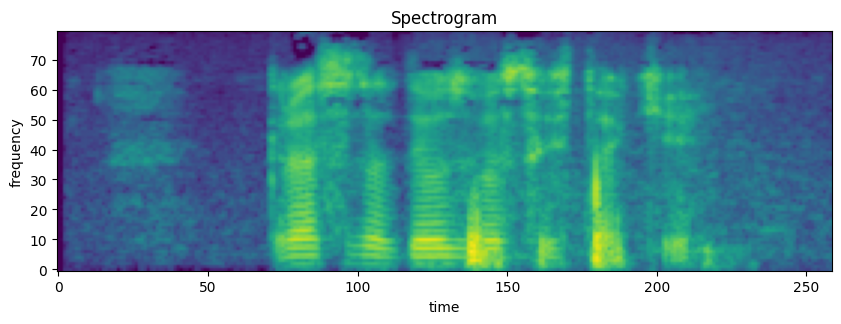

In [4]:
from main.utils.visualizar import vizualizar_spectrogram, audio_duracao
from main.pre_processamento.spectograma import gerar_mel_spectogram
import torchaudio

rate_padrao = 22050
path1 = "dataset/cv-corpus-mozilla-pt/pt/clips/common_voice_pt_19273359.mp3"
signal, rate = torchaudio.load(path1)
print(signal.shape)
signal = fix_audio_length(signal, rate)

print(f"tempo : {audio_duracao(signal,rate)}")
print(signal.shape)

spectrogram = gerar_mel_spectogram(signal,rate_original=rate, rate_alvo=rate_padrao)

vizualizar_spectrogram(spectrogram)
print("mel shape : ", spectrogram.shape)

In [5]:
from main.arquitetura.stableVC.extracao_caracteristicas.conteudo_linguistico import extracao_conteudo_linguistico

extracao_conteudo_linguistico(signal[0])

C:\Users\USER\Documents\Mestrado\codigo\Mestrado_VC\.venv\Lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


array([454, 454, 454, ..., 724, 724, 724], dtype=int32)

# DataLoader

In [5]:
from main.data_loader.CVMPT import CV_mozilla_PT_Dataset
from main.data_loader import criar_dataloader

path_cv = r"C:\Users\USER\Documents\Mestrado\codigo\Mestrado_VC\dataset\cv-corpus-mozilla-pt\pt\clips"
arq_clip = r"C:\Users\USER\Documents\Mestrado\codigo\Mestrado_VC\dataset\cv-corpus-mozilla-pt\pt\clip_durations.tsv"
ext = "mp3"

train_cv = CV_mozilla_PT_Dataset(path_cv, ext=ext ,path_duracoes_tsv_csv=arq_clip, duracao_min_segundos=3,return_mel_spec=True)

data_loader = criar_dataloader(train_cv, batch_size=1)

190024
******* Calculando índices das fatias *******


100%|██████████| 170991/170991 [00:00<00:00, 482040.30it/s]


# Flow matching

In [7]:
from main.arquitetura.stable_vc.modelo.unet.models.unet import UNetModel
from main.arquitetura.stable_vc.modelo.FlowMatching import train_flow_matching
import torch 

dims = 2
model = UNetModel(
    in_channels=1, 
    out_channels=1, 
    channel_mult=(1, 2, 4, 8),
    model_channels=128, 
    dims=dims,
    ).to(device)

optimizer = torch.optim.Adam(model.parameters(), 1e-2)

model, loss_list = train_flow_matching(
    model, 
    data_loader=data_loader, 
    optimizer=optimizer,
    num_epochs=1,
    dims=dims,
    learning_rate=1e-2
)

C:\Users\USER\Documents\Mestrado\codigo\Mestrado_VC\main\metodos\stableVC\modelo\unet\training\grad_scaler.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = torch.cuda.amp.GradScaler()
C:\Users\USER\Documents\Mestrado\codigo\Mestrado_VC\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
1it [00:05,  5.06s/it]

Epoch 0: loss = 198.9550323486328, lr = 0.01
loss: 198.95503


In [8]:
import matplotlib.pyplot as plt

def plot_loss(loss_list, title: str = 'Training Loss'):
    """
    Plota o gráfico de loss ao longo das épocas ou iterações.

    Args:
        loss_list: lista de floats com os valores de loss.
        title: título opcional do gráfico.
    """
    plt.figure()
    plt.plot(loss_list)
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.title(title)
    plt.grid(True)
    plt.show()

#plot_loss(loss_list)

In [9]:
def concatenar_tensor_3d_em_2d(tensor: torch.Tensor) -> torch.Tensor:
    v1 = tensor[0, 0]  # shape (128,)
    v2 = tensor[0, 1]  # shape (128,)
    
    # Concatenar
    out = torch.cat((v1, v2), dim=0)  # shape (256,)
    out = out.unsqueeze(0)  # shape (1, 256)
    return out

# Vocoder

In [10]:
# from IPython.lib.display import Audio
# from main.pesos_arquitetura.stable_vc.vocoder.hifigan import vocoder
# audio = vocoder(spectrogram)
# audio_numpy = audio[0].detach().cpu()
# Audio(audio_numpy, rate=rate_padrao, autoplay=False)

In [11]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

def compute_image_similarity_np(img1: np.ndarray, img2: np.ndarray):
    """
    Calcula a similaridade entre duas imagens (arrays NumPy) utilizando SSIM e MSE.
    
    Parâmetros:
      img1: np.ndarray - primeira imagem (ex.: RGB ou BGR)
      img2: np.ndarray - segunda imagem
      
    Retorna:
      ssim_score: valor do SSIM (de -1 a 1, onde 1 indica imagens idênticas)
      mse_score: erro quadrático médio entre as imagens (valores menores indicam maior similaridade)
    """
    # Verifica se as imagens possuem mesmo tamanho; se não, redimensiona img2 para o tamanho de img1.
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
    
    # Converte para escala de cinza se necessário
    if len(img1.shape) == 3 and img1.shape[2] in [3, 4]:
        gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    else:
        gray1 = img1.copy()
    
    if len(img2.shape) == 3 and img2.shape[2] in [3, 4]:
        gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    else:
        gray2 = img2.copy()
    
    # Se as imagens estiverem em float, determina o intervalo (data_range)
    if np.issubdtype(gray1.dtype, np.floating):
        data_range = float(np.max(gray1) - np.min(gray1))
    else:
        data_range = 255  # assumindo imagens uint8
    
    # Calcula o SSIM entre as imagens
    ssim_score, _ = ssim(gray1, gray2, full=True, data_range=data_range)
    
    # Calcula o Erro Quadrático Médio (MSE)
    mse_score = np.mean((gray1.astype("float") - gray2.astype("float")) ** 2)
    
    return ssim_score, mse_score

# Treinamento

In [12]:
from main.arquitetura.stable_vc.modelo.DitBlock import DiTBlock


def content_module(d_model, conteudo_linguistico,prosody_code,time_emb, timbre_emb, d_style, global_extrator_emb,n_heads,d_ff, qnt_dit:int=1, device="cuda"):
    dit_block = DiTBlock(
        d_model=d_model, 
        d_timbre=timbre_emb.shape[1], 
        d_style=d_style, 
        d_global_speak=global_extrator_emb.shape[1], 
        n_heads=n_heads,
        d_ff=d_ff,
        device=device
    )
    dit_block.train()
    for i in range(qnt_dit):
        # Coloca o modelo em modo de treinamento
        dit_output = dit_block(conteudo_linguistico, timbre_emb, prosody_code, global_extrator_emb, time_emb)
        dit_output = concatenar_tensor_3d_em_2d(dit_output)
        
    return dit_output

def mel_extrator(mel_spec,emb_dim=128,timbre_dim=128):
    # https://github.com/Rumeysakeskin/Speaker-Verification
    mel_extrator = TimbreExtractor(emb_dim=emb_dim, timbre_dim=timbre_dim).to(device)
    timbre_emb, global_extrator_emb = mel_extrator(mel_spec)
    return timbre_emb, global_extrator_emb


def style_extrator():
    pass

# Existe um treinamento aq GRL
def style_encoder():
    pass

In [13]:
from main.arquitetura.stable_vc.extracao_caracteristicas.time_embedding import extracao_time_embedding
from main.arquitetura.stable_vc.extracao_caracteristicas.conteudo_linguistico import content_extrator
from main.arquitetura.stable_vc.extracao_caracteristicas.estilo import extracao_estilo, fa_enc_dec_define
from main.arquitetura.stable_vc.extracao_caracteristicas.TimbreExtractor import TimbreExtractor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fa_encoder, fa_decoder = fa_enc_dec_define()


def train_stableVC(audio_wav,rate_original, rate_alvo, d_model, d_style, n_heads,d_ff, temp_audio: int = 3, epocas = 5000, fre_mels= 80):
    
    # Mel spectograma
    signal = fix_audio_length(audio_wav, rate_original,fixed_duration_sec=temp_audio)[0]
    mel_spec = gerar_mel_spectogram(signal ,rate_original=rate_original, rate_alvo=rate_alvo, n_mels=fre_mels).unsqueeze(0).to(device)
    n_mels = mel_spec.shape[1]
    n_freq = mel_spec.shape[2]
    mel_dim = n_mels * n_freq
    
    # Extracão de caracteristicas
    time_emb = extracao_time_embedding(d_model, num_steps_difusion, batch_size).cuda()
    
    # Content Extractor
    conteudo_linguistico = content_extrator(signal,num_cluster=1024).cuda()
    # Timbre embedding
    timbre_emb, global_extrator_emb = mel_extrator(mel_spec,emb_dim=mel_dim,timbre_dim=mel_dim)

    
    # Content Style
    prosody_code = extracao_estilo(signal.cpu().numpy(),d_style,fa_encoder, fa_decoder, device).cuda().float()
    
    
    # Extracão de caracteristicas
    
    content_module(d_model,conteudo_linguistico,prosody_code, time_emb, timbre_emb, d_style, global_extrator_emb, n_heads, d_ff)

    # Instancia o modelo de Flow Matching
    #flow_model = FlowMatchingModule( mel_dim=mel_dim, d_model=d_model*2, d_style=d_style, hidden_dim=256).to(device)


x_final_img, timbre_db = train_stableVC(signal,rate,rate_padrao, 256,128,n_heads=4,d_ff=256,temp_audio=3, epocas=3000, fre_mels=80)

C:\Users\USER\Documents\Mestrado\codigo\Mestrado_VC\.venv\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
C:\Users\USER\Documents\Mestrado\codigo\Mestrado_VC\main\metodos\stableVC\extracao_caracteristicas\estilo.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user 

ValueError: n_samples=1 should be >= n_clusters=1024.

Visualização

In [ ]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

axes[0].imshow(x_final_img[0].cpu().detach().numpy(), cmap='viridis', origin='lower')
axes[0].set_title("final")

axes[1].imshow(timbre_db[0].cpu().detach().numpy(), cmap='viridis', origin='lower')
axes[1].set_title("original")

ssim_val, mse_val = compute_image_similarity_np(timbre_db[0].cpu().numpy(), x_final_img[0].cpu().numpy())
print(f"SSIM: {ssim_val:.4f} (próximo de 1 indica alta similaridade)")
print(f"MSE: {mse_val:.4f} (valores menores indicam maior similaridade)")

In [ ]:
from IPython.lib.display import Audio
from main.arquitetura.stable_vc.vocoder.hifigan import vocoder

audio = vocoder(x_final_img[0])
audio_numpy = audio[0].detach().cpu()
Audio(audio_numpy, rate=rate_padrao, autoplay=False)

## Exemplo Flow matching

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# 1. Definição do modelo de velocidade (velocity field)
#   Recebe (x, t) e devolve um vetor de mesma dimensão que x
class VelocityField(nn.Module):
    def __init__(self, dim_hidden=64):
        super().__init__()
        # Rede simples MLP
        self.net = nn.Sequential(
            nn.Linear(2 + 1, dim_hidden),  # (x_dim=2, t_dim=1)
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, 2)       # Saída: vetor 2D (velocidade)
        )

    def forward(self, x, t):
        """
        x: Tensor [batch, 2]
        t: Tensor [batch] com valores entre 0 e 1
        """
        # Expandimos t para ter shape [batch, 1]
        t = t.view(-1, 1)
        # Concatenamos (x, t) na última dimensão
        inp = torch.cat([x, t], dim=-1)
        return self.net(inp)

# 2. Função auxiliar para gerar pares (x_0, x_1)
#   x_1: amostras do conjunto "moons" (distribuição alvo)
#   x_0: amostras de ruído Gaussiano (distribuição de origem)
def generate_pairs(batch_size=128):
    # Gera dados de "moons"
    x1, _ = make_moons(n_samples=batch_size, noise=0.05)
    x1 = torch.tensor(x1, dtype=torch.float32)

    # Gera dados Gaussiano
    x0 = torch.randn_like(x1)
    return x0, x1

# 3. Loop de treinamento do Flow Matching
#   Objetivo: forçar o velocity field a reproduzir a "trajetória linear" entre x0 e x1
#   A "trajetória" no tempo t é: x_t = (1 - t)*x0 + t*x1
#   O vetor velocidade ideal é: d/dt (x_t) = x1 - x0
#   (Isso corresponde a um caso simples de "Conditional OT Path")
def train_flow_matching(epochs=2000, batch_size=128, lr=1e-3):
    model = VelocityField().train()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for step in range(epochs):
        x0, x1 = generate_pairs(batch_size)

        # Amostramos tempos aleatórios t ~ Uniform(0, 1)
        t = torch.rand(batch_size)

        # x_t = (1 - t)*x0 + t*x1
        x_t = (1 - t).unsqueeze(1)*x0 + t.unsqueeze(1)*x1

        # A velocidade verdadeira nesse caminho linear é (x1 - x0)
        true_velocity = x1 - x0  # shape [batch, 2]

        # Predição do modelo
        pred_velocity = model(x_t, t)

        # Erro = MSE entre velocidade predita e velocidade "ideal"
        loss = ((pred_velocity - true_velocity)**2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (step+1) % 500 == 0:
            print(f"Step {step+1}/{epochs}, Loss = {loss.item():.4f}")

    return model

# 4. Função de amostragem (inferência)
#   Dado um batch de x0, aplicamos integração de Euler no tempo [0, 1]
def sample_flow(model, x0, steps=50):
    model.eval()
    # Dividimos o intervalo [0,1] em 'steps' passos
    t_vals = torch.linspace(0, 1, steps)
    x_t = x0.clone()

    for i in range(steps-1):
        t = t_vals[i]
        dt = t_vals[i+1] - t

        # Estimamos a velocidade v = u_t(x_t)
        v = model(x_t, torch.full_like(x_t[:, 0], t))
        # x_{t+dt} ~ x_t + dt*v
        x_t = x_t + dt*v

    return x_t

# 5. Exemplo de uso
if __name__ == "__main__":
    # Treinamos o velocity field
    model = train_flow_matching(epochs=10000, batch_size=256)

    # Amostramos alguns x0 (Gaussiano)
    x0_test = torch.randn(300, 2)

    # Geramos amostras x1 "convertidas" pela integração
    x1_gen = sample_flow(model, x0_test, steps=50)

    # Plot
    x0_np = x0_test.detach().numpy()
    x1_np = x1_gen.detach().numpy()

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.title("Distribuição Origem (x0)")
    plt.scatter(x0_np[:,0], x0_np[:,1], s=10, alpha=0.7)

    plt.subplot(1,2,2)
    plt.title("Distribuição Gerada (x1_gen)")
    plt.scatter(x1_np[:,0], x1_np[:,1], s=10, alpha=0.7)
    plt.show()
